# Build keypoint code

Then, use it sequentially on small windows to stitch tracklets together

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import pandas as pd
%load_ext autoreload
%autoreload 2

from DLC_for_WBFM.utils.feature_detection.utils_features import *
from DLC_for_WBFM.utils.feature_detection.utils_tracklets import *
from DLC_for_WBFM.utils.feature_detection.utils_detection import *
from DLC_for_WBFM.utils.feature_detection.visualization_tracks import *
from DLC_for_WBFM.utils.feature_detection.feature_pipeline import *
from DLC_for_WBFM.utils.feature_detection.utils_affine import *
from DLC_for_WBFM.utils.feature_detection.class_reference_frame import PreprocessingSettings
import pickle
from collections import defaultdict


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
which_suffix = 'prealigned'

fname = f'clust_df_dat_{which_suffix}.pickle'
with open(fname, 'rb') as f:
    clust_df = pickle.load(f)
    
# fname = f'match_dat_{which_suffix}.pickle'
# with open(fname, 'rb') as f:
#     all_matches, all_conf = pickle.load(f)

In [14]:
a = np.array([True, True, False])
a[a==1]

array([ True,  True])

In [27]:

# Getting keypoints
def separate_keypoints_and_tracklets(clust_df, start_ind, window_length, 
                                     min_tracklet_overlap=3,
                                     min_required_keypoints=10):
    """
    For a given window, separates tracklets into two categories:
        Keypoints, which are tracked in the entire window
        Tracklets, which have at least 'min_tracklet_overlap' frames in the window
    """
    
    is_keypoint = []
    is_tracklet = []
    this_window = list(range(start_ind, start_ind + window_length))
    for i, row in enumerate(clust_df['slice_ind']):
        overlap_ind = np.array([i in this_window for i in row])
        num_overlap = np.count_nonzero(overlap_ind)
        if num_overlap < min_tracklet_overlap:
            continue
        elif num_overlap == window_length:
            is_keypoint.append(i)
        elif num_overlap <= (window_length-min_tracklet_overlap):
            # If it is nearly the entire window, then it can't match with anything
            is_tracklet.append(i)
            
    kp_df = clust_df.iloc[is_keypoint]
    tracklet_df = clust_df.iloc[is_tracklet]
    
    if len(kp_df) < min_required_keypoints:
        print(f"Warning, few keypoints ({len(kp_df)}) detected")
    
    return kp_df, tracklet_df

In [192]:
# Building features
def calc_vectors(this_neuron, kp_df, slice_ind):
    one_neuron_vectors = []
    this_neuron = np.array(this_neuron)
    for _, kp in kp_df.iterrows():
        # The tracks are long, so only do the point at slice_ind
        kp_ind = kp['slice_ind'].index(slice_ind)
        kp_neuron = np.array(kp['all_xyz'][kp_ind])
        one_neuron_vectors.append(this_neuron - kp_neuron)
        
    return one_neuron_vectors


def calc_features_from_vectors(one_neuron_vectors):
    """Todo: refactor to be smarter with inner product"""
    n = len(one_neuron_vectors)
    one_neuron_features = []
    for i1 in range(n):
        for i2 in range(i1+1, n):
            v1, v2 = one_neuron_vectors[i1], one_neuron_vectors[i2]
            one_neuron_features.append(np.dot(v1, v2))
    
    return one_neuron_features


def calc_all_tracklet_features(kp_df, tracklet_df, start_ind, window_length, verbose=1):
    """
    Processes tracklet dataframe, returning a list of features
    
    The indices of this list correspond to the overlap with the window
    """
    
    this_window = list(range(start_ind, start_ind + window_length))
    all_tracklet_features = []
    if verbose >= 1:
        print("Calculating features for all tracklets")
    for _, tracklet in tqdm(tracklet_df.iterrows(), total=len(tracklet_df)):
        this_tracklet_features = []
        for global_ind in this_window:
            if global_ind in tracklet['slice_ind']:
                tracklet_ind = tracklet['slice_ind'].index(global_ind)
                this_neuron = tracklet['all_xyz'][tracklet_ind]
            else:
                continue
            these_vectors = calc_vectors(this_neuron, kp_df, global_ind)
            tmp = calc_features_from_vectors(these_vectors)
            this_tracklet_features.append(tmp)
        all_tracklet_features.append(this_tracklet_features)
    
    return all_tracklet_features

In [168]:
# Building low-d space and classifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import svm

def calc_one_stable_space(x):
    """Uses last 2 PCA modes"""
    # Build space
    x = np.array(x)
    x_std = StandardScaler().fit_transform(x)
    transformer = PCA()
    transformer.fit(x_std)
    # Build classifier
    # See: https://scikit-learn.org/stable/modules/outlier_detection.html
    x_projected = transformer.transform(x)
    classifier = svm.OneClassSVM(nu=0.1, kernel='rbf')
    classifier.fit(x_projected[:,-2:])
    
    return transformer, classifier


def calc_all_subspaces(all_tracklet_features):
    """
    Calculates all stable subspaces
    Note that it doesn't return the features of the tracklet in its own subspace
    [only returns the classifier]
    """
    
    all_transformers, all_classifiers = [], []
    for tracklet_features in all_tracklet_features:
        this_transformer, this_classifier = calc_one_stable_space(tracklet_features)
        all_transformers.append(this_transformer)
        all_classifiers.append(this_classifier)
    
    return all_transformers, all_classifiers

In [199]:
# Classifying all tracklets and stitching
def calc_tracklet_label(other_x, this_t, this_c):
    """Greedy tracklet labeling based on voting of each individual neuron within the tracklet"""
    these_other, these_confidences = [], []
    for i1, x in other_x.items():
        x_t = this_t.transform(x)
        pred = this_c.predict(x_t[:,-2:])
        conf = np.count_nonzero(pred==1)/len(pred)
        if conf > 0.0:
            these_other.append(i1)
            these_confidences.append(conf)
    
    return these_other, these_confidences


def match_tracklets(tracklet_df, all_tracklet_features, all_transformers, all_classifiers):
    
    all_matches = []
    num_tracklets = len(tracklet_df)
    for i0, (_,this_tracklet) in enumerate(tracklet_df.iterrows()):
        # Don't even attempt a match if the neurons are simultaneously identified
        # TODO: should I really treat the tracklets as 100% accurate?
        this_t, this_c = all_transformers[i0], all_classifiers[i0]
        these_ind = set(this_tracklet['slice_ind'])
        other_x = {}
        for i1 in range(num_tracklets):
            if i0==i1:
                continue
            other_tracklet = tracklet_df.iloc[i1]
            other_ind = set(other_tracklet['slice_ind'])
            if len(these_ind.intersection(other_ind))==0:
                other_x[i1] = all_tracklet_features[i1]
        these_other, these_confidences = calc_tracklet_label(other_x, this_t, this_c)
        # Cast in graph format
        m = [[i0, i1, c] for i1, c in zip(these_other, these_confidences)]
        all_matches.extend(m)
    
    return all_matches

## Test it

In [101]:
start_ind = 50
window_length = 20
kp_df, tracklet_df = separate_keypoints_and_tracklets(clust_df, start_ind, window_length, min_tracklet_overlap=7)

In [102]:
all_tracklet_features = calc_all_tracklet_features(kp_df, tracklet_df, start_ind, window_length)

  3%|██▏                                                                                 | 2/79 [00:00<00:04, 17.24it/s]

Calculating features for all tracklets


100%|███████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.84it/s]


In [111]:
print(len(all_tracklet_features))
print(len(all_tracklet_features[0]))
print(len(all_tracklet_features[3][0]))

79
13
1225


## Visualize the stable subspaces

In [169]:
all_t, all_c = [], []
for x in all_tracklet_features:
    t, c = calc_one_stable_space(x)
    all_t.append(t)
    all_c.append(c)


In [146]:
%matplotlib notebook
which_space = 1
t = all_t[which_space]
num_tracks = 50

all_x = []
for i,x in enumerate(all_tracklet_features):
    if i > num_tracks:
        break
    if i == which_space:
        label = 'original'
    else:
        label = f'neuron{i}'
    x_t = t.transform(x)
    plt.scatter(x_t[:,-2],x_t[:,-1], label=label)
    
plt.legend()
plt.title(f"All neurons in the stable space of neuron {which_space}")

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'All neurons in the stable space of neuron 1')

interactive(children=(IntSlider(value=0, description='which_space', max=79), IntSlider(value=1, description='w…

<function __main__.f(which_space=0, which_other=1)>

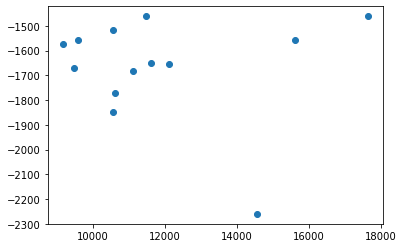

In [154]:
from ipywidgets import interact
%matplotlib inline
def f(which_space=0, which_other=1):
    t = all_t[which_space]
    c = all_c[which_space]
    
    plt.figure()
    x = all_tracklet_features[which_space]
    x_t = t.transform(x)
    plt.scatter(x_t[:,-2],x_t[:,-1], label='original')
    
    x = all_tracklet_features[which_other]
    x_t = t.transform(x)
    plt.scatter(x_t[:,-2],x_t[:,-1], label='other')
    plt.legend()

span = (0,len(all_tracklet_features)-1)
interact(f, which_space=span, which_other=span)

In [177]:
which_space = 0
# which_dat = 4

print("Neuron, Confidence, Slices spanned by the tracklet")
for i, which_dat in enumerate(range(len(all_tracklet_features))):
    x = all_tracklet_features[which_dat]
    x_t = all_t[which_space].transform(x)
    pred = all_c[which_space].predict(x_t[:,-2:])
    conf = np.count_nonzero(pred==1)/len(pred)
    if conf > 0.0:
        print(i, conf, tracklet_df.iloc[i]['slice_ind'])

Neuron, Confidence, Slices spanned by the tracklet
0 0.8461538461538461 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]
6 0.2727272727272727 [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
7 0.18181818181818182 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
8 0.2727272727272727 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
9 0

## Get the candidate matches

In [182]:
all_transformers, all_classifiers = calc_all_subspaces(all_tracklet_features)

In [200]:
all_matches = match_tracklets(tracklet_df, all_tracklet_features, all_transformers, all_classifiers)

In [201]:
all_matches

[[0, 75, 0.14285714285714285],
 [0, 77, 0.7142857142857143],
 [1, 61, 0.25],
 [1, 70, 0.2222222222222222],
 [2, 56, 0.8181818181818182],
 [2, 66, 0.6666666666666666],
 [2, 72, 0.3333333333333333],
 [3, 75, 0.8571428571428571],
 [3, 78, 0.14285714285714285],
 [6, 66, 0.1111111111111111],
 [6, 68, 0.1111111111111111],
 [6, 70, 0.2222222222222222],
 [7, 66, 0.7777777777777778],
 [7, 67, 0.2222222222222222],
 [7, 71, 0.5714285714285714],
 [7, 72, 0.5555555555555556],
 [7, 75, 0.5714285714285714],
 [7, 77, 0.14285714285714285],
 [8, 66, 0.1111111111111111],
 [8, 67, 0.1111111111111111],
 [8, 68, 0.1111111111111111],
 [8, 70, 0.1111111111111111],
 [8, 74, 0.125],
 [8, 76, 0.2857142857142857],
 [8, 77, 0.2857142857142857],
 [9, 73, 0.2857142857142857],
 [9, 75, 0.42857142857142855],
 [9, 77, 0.42857142857142855],
 [10, 73, 0.14285714285714285],
 [10, 77, 0.2857142857142857],
 [11, 58, 0.2],
 [11, 59, 0.3],
 [11, 60, 0.4],
 [11, 62, 0.1],
 [11, 63, 0.1],
 [11, 78, 0.2857142857142857],
 [12, 78

In [191]:
for i0, this_tracklet in enumerate(tracklet_df.itertuples()):
    print(this_tracklet)

Pandas(Index=10, clust_ind=10, all_ind_local=[13, 23, 10, 52, 40, 62, 81, 136, 50, 23, 102, 138, 51, 110, 126, 139, 135, 130, 130, 131, 131, 120, 62, 61, 95, 128, 133, 128, 126, 135, 143, 134, 127, 133, 128, 138, 123, 128, 121, 132, 128, 131, 124, 93, 119, 118, 137, 132, 139, 138, 146, 140, 132, 141, 145, 142, 146, 139, 143, 140, 142, 157, 162], all_ind_global=[13, 171, 330, 551, 710, 891, 1040, 1266, 1348, 1498, 1720, 1968, 2087, 2293, 2456, 2615, 2759, 2900, 3049, 3195, 3337, 3474, 3559, 3698, 3878, 4055, 4205, 4345, 4492, 4650, 4813, 4963, 5109, 5261, 5404, 5559, 5695, 5845, 5982, 6137, 6285, 6436, 6590, 6713, 6890, 7036, 7211, 7362, 7521, 7678, 7843, 7986, 8129, 8281, 8435, 8582, 8738, 8884, 9039, 9188, 9337, 9508, 9681], all_xyz=array([[ 12.5       , 476.65764618, 209.77298355],
       [  7.5       , 500.9401474 , 232.95420837],
       [  7.5       , 490.39998169, 214.39437561],
       [ 15.5       , 476.01079941, 322.82612228],
       [ 15.5       , 503.7923317 , 271.44240189],
 

In [189]:
tracklet_df.itertuples?